In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [2]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [3]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [4]:
data = read_text("german.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [5]:
deu_eng = deu_eng[:50000,:]

In [6]:
deu_eng

array([['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ['Run!', 'Lauf!'],
       ...,
       ['Tom held on to the rope.', 'Tom hielt sich am Seil fest.'],
       ['Tom hid behind the door.',
        'Tom versteckte sich hinter der Tür.'],
       ['Tom hid under the table.', 'Tom versteckte sic']], dtype='<U83')

In [7]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ['Run', 'Lauf'],
       ...,
       ['Tom held on to the rope', 'Tom hielt sich am Seil fest'],
       ['Tom hid behind the door', 'Tom versteckte sich hinter der Tür'],
       ['Tom hid under the table', 'Tom versteckte sic']], dtype='<U83')

In [8]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ['run', 'lauf'],
       ...,
       ['tom held on to the rope', 'tom hielt sich am seil fest'],
       ['tom hid behind the door', 'tom versteckte sich hinter der tür'],
       ['tom hid under the table', 'tom versteckte sic']], dtype='<U83')

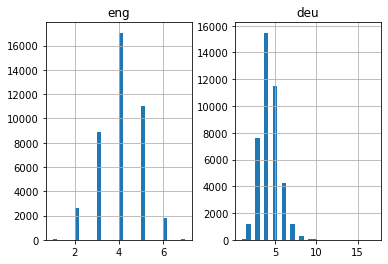

In [9]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [10]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [11]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6069


In [12]:
# prepare german tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('German Vocabulary Size: %d' % deu_vocab_size)

German Vocabulary Size: 10385


In [13]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [14]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [15]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [16]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [17]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [18]:
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [19]:
filename = 'model'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
52/52 [==============================] - 155s 2s/step - loss: 4.7316 - val_loss: 3.1245

Epoch 00001: val_loss improved from inf to 3.12454, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 2/30
52/52 [==============================] - 120s 2s/step - loss: 3.1127 - val_loss: 3.0542

Epoch 00002: val_loss improved from 3.12454 to 3.05417, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 3/30
52/52 [==============================] - 119s 2s/step - loss: 2.9893 - val_loss: 2.9736

Epoch 00003: val_loss improved from 3.05417 to 2.97362, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 4/30
52/52 [==============================] - 118s 2s/step - loss: 2.8459 - val_loss: 2.8030

Epoch 00004: val_loss improved from 2.97362 to 2.80300, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 5/30
52/52 [==============================] - 123s 2s/step - loss: 2.6814 - val_loss: 2.7020

Epoch 00005: val_loss improved from 2.80300 to 2.70202, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 6/30
52/52 [==============================] - 140s 3s/step - loss: 2.5467 - val_loss: 2.6075

Epoch 00006: val_loss improved from 2.70202 to 2.60751, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 7/30
52/52 [==============================] - 155s 3s/step - loss: 2.4276 - val_loss: 2.5374

Epoch 00007: val_loss improved from 2.60751 to 2.53738, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 8/30
52/52 [==============================] - 147s 3s/step - loss: 2.3141 - val_loss: 2.4713

Epoch 00008: val_loss improved from 2.53738 to 2.47130, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 9/30
52/52 [==============================] - 169s 3s/step - loss: 2.2010 - val_loss: 2.3645

Epoch 00009: val_loss improved from 2.47130 to 2.36447, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 10/30
52/52 [==============================] - 157s 3s/step - loss: 2.0971 - val_loss: 2.2961

Epoch 00010: val_loss improved from 2.36447 to 2.29608, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 11/30
52/52 [==============================] - 151s 3s/step - loss: 1.9969 - val_loss: 2.2729

Epoch 00011: val_loss improved from 2.29608 to 2.27289, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 12/30
52/52 [==============================] - 146s 3s/step - loss: 1.9061 - val_loss: 2.1787

Epoch 00012: val_loss improved from 2.27289 to 2.17874, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 13/30
52/52 [==============================] - 155s 3s/step - loss: 1.7968 - val_loss: 2.1417

Epoch 00013: val_loss improved from 2.17874 to 2.14169, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 14/30
52/52 [==============================] - 129s 2s/step - loss: 1.7166 - val_loss: 2.0670

Epoch 00014: val_loss improved from 2.14169 to 2.06702, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 15/30
52/52 [==============================] - 142s 3s/step - loss: 1.6199 - val_loss: 2.0494

Epoch 00015: val_loss improved from 2.06702 to 2.04945, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 16/30
52/52 [==============================] - 130s 3s/step - loss: 1.5260 - val_loss: 1.9836

Epoch 00016: val_loss improved from 2.04945 to 1.98364, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 17/30
52/52 [==============================] - 168s 3s/step - loss: 1.4443 - val_loss: 1.9407

Epoch 00017: val_loss improved from 1.98364 to 1.94074, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 18/30
52/52 [==============================] - 149s 3s/step - loss: 1.3701 - val_loss: 1.9013

Epoch 00018: val_loss improved from 1.94074 to 1.90125, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 19/30
52/52 [==============================] - 151s 3s/step - loss: 1.2882 - val_loss: 1.8554

Epoch 00019: val_loss improved from 1.90125 to 1.85541, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 20/30
52/52 [==============================] - 158s 3s/step - loss: 1.2096 - val_loss: 1.8306

Epoch 00020: val_loss improved from 1.85541 to 1.83056, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 21/30
52/52 [==============================] - 167s 3s/step - loss: 1.1432 - val_loss: 1.8091

Epoch 00021: val_loss improved from 1.83056 to 1.80906, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 22/30
52/52 [==============================] - 161s 3s/step - loss: 1.0664 - val_loss: 1.7713

Epoch 00022: val_loss improved from 1.80906 to 1.77131, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 23/30
52/52 [==============================] - 157s 3s/step - loss: 0.9974 - val_loss: 1.7621

Epoch 00023: val_loss improved from 1.77131 to 1.76212, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 24/30
52/52 [==============================] - 159s 3s/step - loss: 0.9365 - val_loss: 1.7303

Epoch 00024: val_loss improved from 1.76212 to 1.73032, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 25/30
52/52 [==============================] - 159s 3s/step - loss: 0.8670 - val_loss: 1.7189

Epoch 00025: val_loss improved from 1.73032 to 1.71887, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 26/30
52/52 [==============================] - 167s 3s/step - loss: 0.8151 - val_loss: 1.7125

Epoch 00026: val_loss improved from 1.71887 to 1.71252, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 27/30
52/52 [==============================] - 147s 3s/step - loss: 0.7655 - val_loss: 1.6781

Epoch 00027: val_loss improved from 1.71252 to 1.67810, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 28/30
52/52 [==============================] - 174s 3s/step - loss: 0.7086 - val_loss: 1.6870

Epoch 00028: val_loss did not improve from 1.67810
Epoch 29/30
52/52 [==============================] - 175s 3s/step - loss: 0.6574 - val_loss: 1.6550

Epoch 00029: val_loss improved from 1.67810 to 1.65497, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Epoch 30/30
52/52 [==============================] - 869s 17s/step - loss: 0.6074 - val_loss: 1.6514

Epoch 00030: val_loss improved from 1.65497 to 1.65138, saving model to model


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


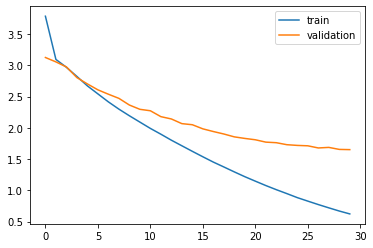

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [21]:
model = load_model('model')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [22]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [23]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [24]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [25]:
# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
1047,she turned on the light,she on the
3257,i dont hear anything,i dont hear anything
5707,what are you afraid of,what are you afraid of
2773,i like to play tennis,i like playing tennis
7244,i want to talk to him,i want to talk to talk
2826,she got up late,she is late
7606,where is my luggage,wheres is my
7453,we are his sons,were left is red
3514,youre not my type,youre not my type
3801,i am trying to help him,i trying to help
